In [1]:
%matplotlib widget

In [2]:
from functools import partial

In [3]:
from libschrodinger.crank_nicolson_2d import *

In [4]:
from libschrodinger.potentials import *

In [5]:
from libschrodinger.campaigns import *

In [6]:
import numpy as np

In [7]:
import pandas as pd

In [8]:
from pathlib import Path

In [9]:
from typing import Dict

In [10]:
caseName : str = "lightspeed2"

In [11]:
class PropigationDirection(Enum): 
    Forward : float = 1
    Backward : float = -1

In [12]:
def makeNonDispersiveWavePacket(
            grid, 
            startX : float, 
            startY : float, 
            angularFrequency : float, 
            speedOfLight : float, 
            sigma : float, 
            direction : PropigationDirection = PropigationDirection.Backward
        ): 
    waveNumber = angularFrequency / speedOfLight
    ##wave = np.exp(1j * waveNumber * ((grid.x - startX) + (grid.y - startY)))
    #wave = np.exp((-grid.x ** 2 + 1j * waveNumber * grid.x) + (-grid.y ** 2 + 1j * waveNumber * grid.y))
    #amplitude = (1 / np.sqrt(2))
    #return wave
    velocityPart = math.exp(1j * waveNumber * (grid.x - startX))
    stationaryPart = math.exp(-1 / 2 * ((grid.x - startX) ** 2 + (grid.y - startY) ** 2) / sigma ** 2)
    return stationaryPart * velocityPart


In [13]:
math = np
spatialStep : float = .01
length : float = 1
temporalStep : float = (spatialStep ** 2) / 4
courantNumber : float = 1.0
pointCount : int = int(length / spatialStep)
potentialHeight : float = 200
preRegionLength = .3
preRegionScalar = 10
packetStandardDeviation : float = preRegionLength / preRegionScalar
packetStartX : float = 1 - ((preRegionScalar / 2) * packetStandardDeviation)
packetStartY : float = .5
angularFrequency : float = 1.0
speedOfLight : float = 1.0
#packetWaveNumber : float = 13 * np.pi

barrierCount : int = 3
postRegionLength = .3
intraRegionLength : float = 1 - (postRegionLength + preRegionLength)
barrierWidth : float = intraRegionLength / barrierCount
constantPotentialLengthRatios : List[float] = [postRegionLength] \
        + ([barrierWidth] * barrierCount) \
        + [preRegionLength]
print("Point Count: ", pointCount)
print("Post Region Length: ", postRegionLength)
print("Intra Region Length: ", intraRegionLength)
print("Pre Region Length: ", preRegionLength)
print("Barrier Length: ", barrierWidth)
print("Total Length: ", intraRegionLength + postRegionLength + preRegionLength)
print("Total Length Ratios: ", np.sum(constantPotentialLengthRatios))
frameCount : int = 650
backend = "numpy"

Point Count:  100
Post Region Length:  0.3
Intra Region Length:  0.4
Pre Region Length:  0.3
Barrier Length:  0.13333333333333333
Total Length:  1.0
Total Length Ratios:  1.0


In [14]:
wavePacketFunction = lambda position : makeNonDispersiveWavePacket(
            position, 
            packetStartX * length, 
            packetStartY * length, 
            angularFrequency, 
            speedOfLight, 
            packetStandardDeviation
        )

In [15]:
potentials : List[List[float]] = [
        [0, 0, 0, 0, 0]
    ]

In [16]:
profiles : List[SimulationProfile] = constantSimulationProfiles(
        wavePacketFunction, 
        spatialStep, 
        temporalStep, 
        length, 
        constantPotentialLengthRatios, 
        potentials, 
        False, 
        pointCount, 
        False, 
        edgeBound = True
    )

In [17]:
constantPotentialLengthRatios

[0.3, 0.13333333333333333, 0.13333333333333333, 0.13333333333333333, 0.3]

In [18]:
allData, simulations = recordConstantRegionSimulations(
        profiles, 
        frameCount, 
        caseName, 
        constantPotentialLengthRatios, 
        True, 
        constantRegionLabels = ["Post", "3rdStair", "2ndStair", "1stStair", "Pre"], 
        showBar = True, 
        showFPS = True, 
        showTotalTime = True, 
        discardSimulations = False
    )

[====================================================================================================]
[----------------------------------------------------------------------------------------------------]
Total Time:  38.64200814799551
Frames Per Second:  16.85423513351514
Simulation 0 is done, processing probabilities.
Simulation 0: done processing probabilities.
Simulation 0: logging.
Saving Video of lightspeed20
Saving Video of Post
Saving Video of 3rdStair
Saving Video of 2ndStair
Saving Video of 1stStair
Saving Video of Pre
Done logging lightspeed20
Producing Simulation final output CSV


In [19]:
allData["packetStartX"] = packetStartX
allData["packetStartY"] = packetStartY
allData["initialWaveNumber"] = "NULL"#packetWaveNumber
allData["standardDeviation"] = packetStandardDeviation

In [20]:
pd.DataFrame(allData).to_csv(str(Path.cwd() / caseName / (caseName + ".csv")))

In [110]:
from numpy.fft import fft, ifft

In [111]:
packetCenterColumnIndex : int = int(packetStartX * pointCount)

In [112]:
sliceColumn = packetCenterColumnIndex

In [148]:
probabilityFft = ifft(simulations[0].probabilities[0][:, sliceColumn])

In [149]:
x = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])

In [150]:
x[1, : ]

array([3, 4, 5])

<Figure size 640x480 with 0 Axes>

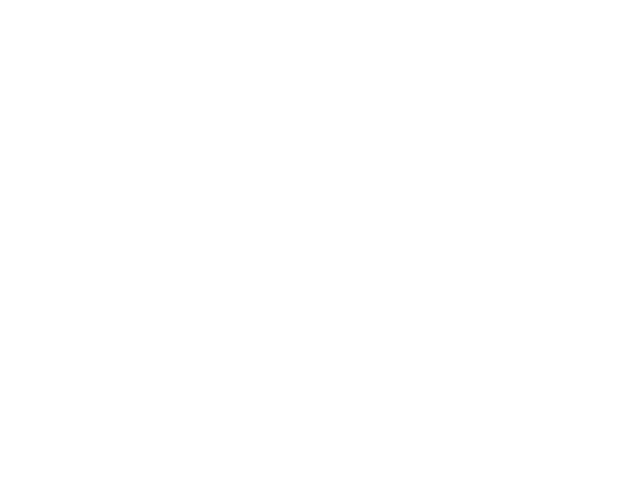

In [151]:
plt.figure()

In [152]:
conjugated = probabilityFft * np.conj(probabilityFft)

In [153]:
plt.plot(np.float64(conjugated))

/tmp/ipykernel_1472/3457636767.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.plot(np.float64(conjugated))
